#

In [0]:
begin
    using DrWatson
    using FHist
    using HDF5
    using StatsBase: sample
    using DataFrames
    using DimensionalData
    using DimensionalData: dims
    using StatsBase: mean
    using Beforerr
    import CairoMakie.Makie.SpecApi as S
    include("../src/io.jl")
    include("../src/plot.jl")
    include("../src/jump.jl")
    include("../src/mix_rates.jl")

    TM_OBS_FILE = "tm_obs.jld2"

    VMIN = 0.25
    VMAX = 256
end

# Mixing rates

## Transition matrix approach

In [0]:
using EasyFit

# Load the data
d = wload(datadir(TM_OBS_FILE))
df = d["df"]
vPs = d["vPs"]
tms = d["tms"]
ergs_approx = ["~10 eV", "~100 eV", "~5 keV", "~100 keV", "~1 MeV"]

r = 0:200
res = map(tms) do tm
    mix_rate(tm).(r)
end

fit_label(f) = L"D_{μμ} = %$(round(1 / f.b, digits=2))"
xlabel = L"n"
# Plot the mixing rate
function plot_mixing_rate!(res)
    options = Options(nbest=8, besttol=1e-5)
    map(res) do re
        N = length(re)
        sca = scatter!(1:N, re)
        fit = fitexp(1:N, re; options)
        lin = lines!(fit.x, fit.y)
        [sca, lin, fit]
    end
end

f1 = let labels = ergs_approx, ax = (; xlabel, ylabel="M_2(∞) - M_2(n)", xscale=log10, yscale=log10)
    data = map(res[2:end]) do re
        last(re) .- re
    end
    f = Figure()
    ax = Axis(f[1, 1]; ax...)
    contents = plot_mixing_rate!(data)
    labels = LaTeXString.(ergs_approx[2:end] .* "(" .* fit_label.(getindex.(contents, 3)) .* ")")
    contents = getindex.(contents, Ref([1, 2]))
    axislegend(ax, contents, labels, "Energy"; position=:rb)
    xlims!(1.5, 200)
    ylims!(3e-2, 3e-1)
end

f2 = let labels = ergs_approx, ax = (; xlabel, ylabel=L"M_2(n)", xscale=log10, yscale=log10)
    data = res[2:end]
    f = Figure()
    ax = Axis(f[1, 1]; ax...)
    contents = plot_mixing_rate!(data)
    labels = LaTeXString.(ergs_approx[2:end] .* "(" .* fit_label.(getindex.(contents, 3)) .* ")")
    contents = getindex.(contents, Ref([1, 2]))
    axislegend(ax, contents, labels, "Energy"; position=:rb)
    xlims!(1.5, 200)
    ylims!(3e-2, 3e-1)
    easy_save("mixing_rate")
end
f2

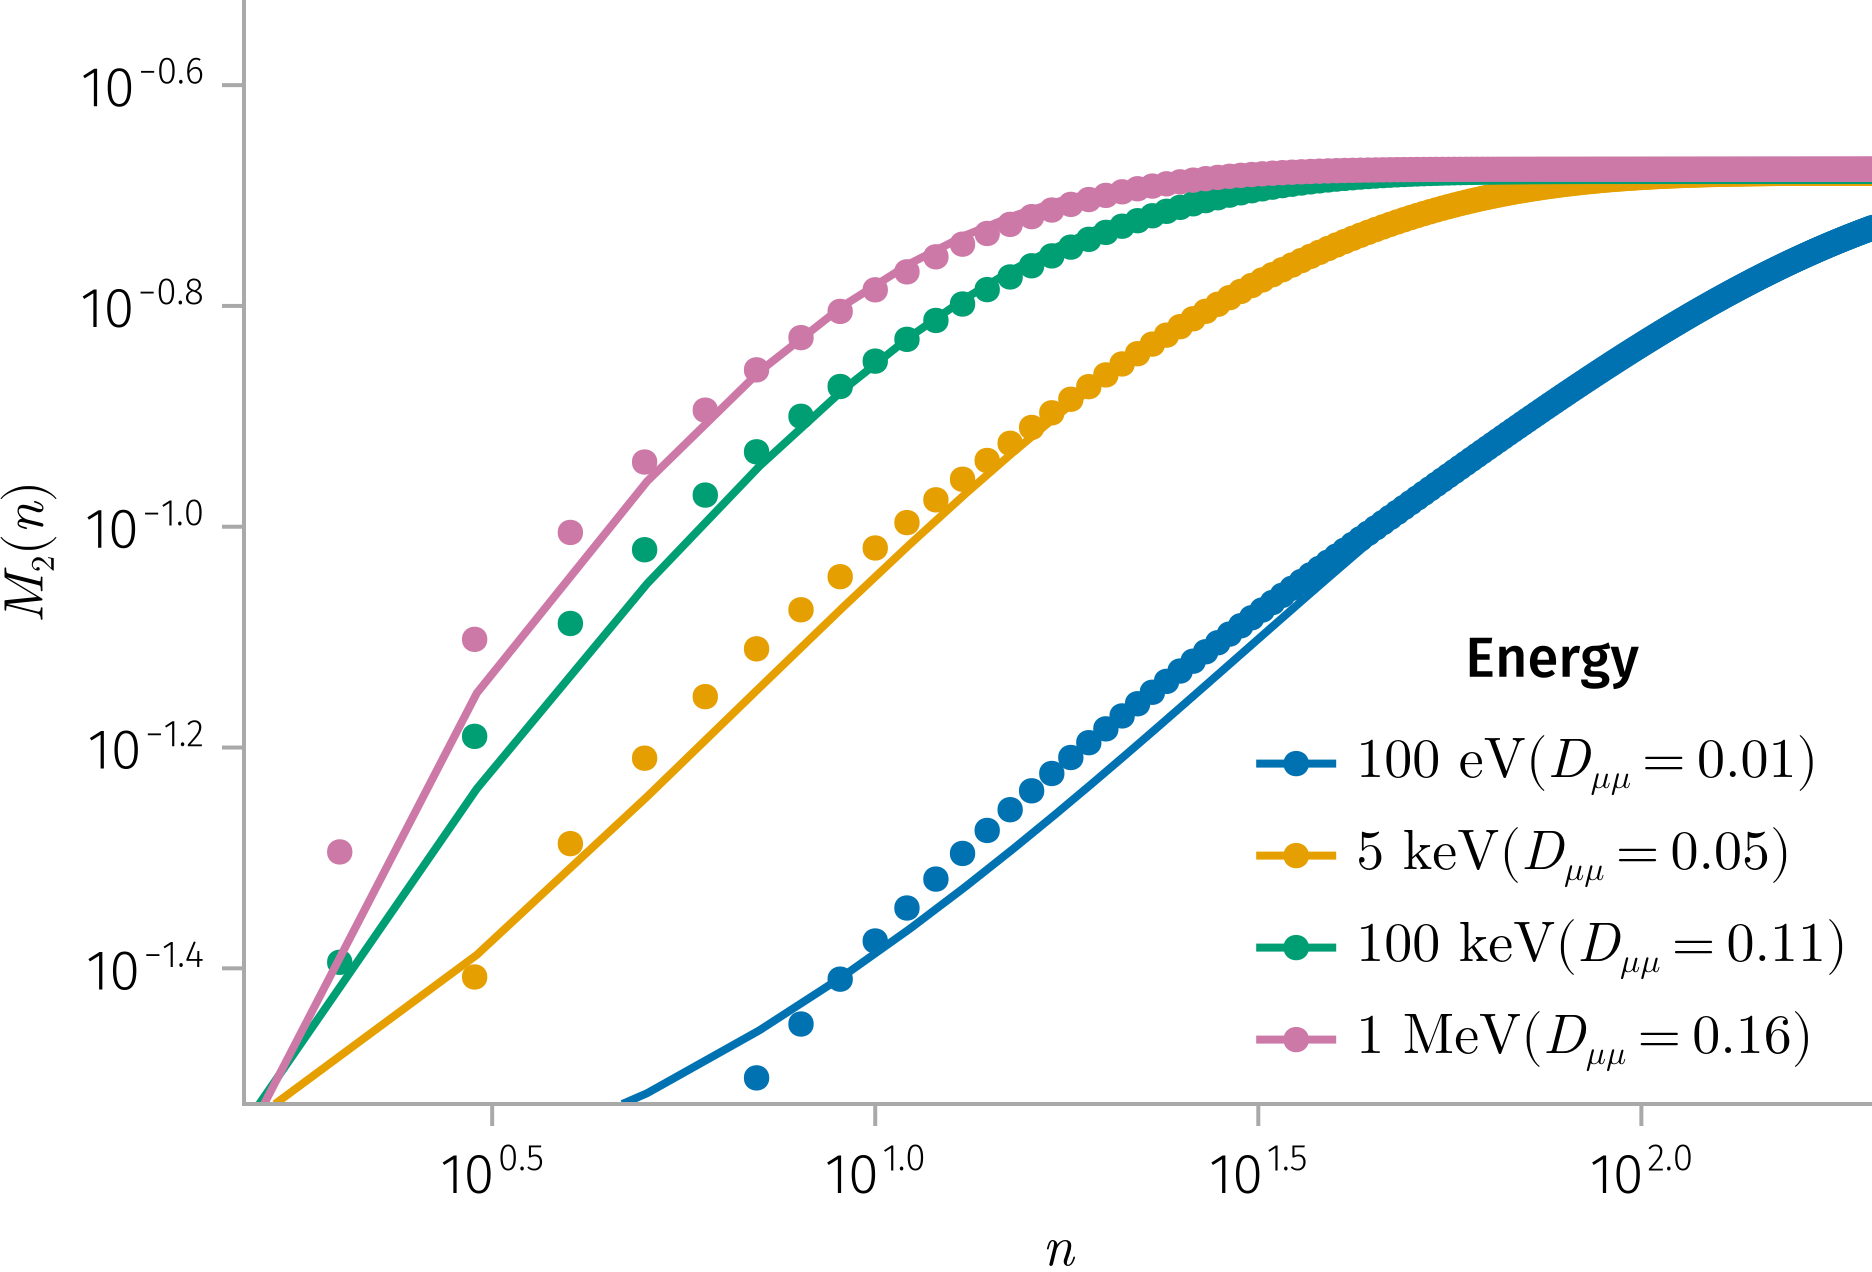

## ECDF approach (better)

In [0]:
dir = "simulations"
dfs = get_result_dfs(; dir)

In [0]:
foreach(get_result!, eachrow(dfs))
@rtransform!(dfs, :ecdf_da = ecdf_da(:results, "s2α0", "Δs2α"))
@rtransform!(dfs, :ecdf_μ = ecdf_da(:results, "μ0", "Δμ"))

In [0]:
function load_obs_hist(; file=datadir("obs/") * "wind_hist3d.h5")
    h = h5readhist(file, "hist")
    bc = bincenters(h)
    vs = 2 .^ bc[1]
    βs = bc[2] ./ 2
    θs = bc[3]
    return DimArray(bincounts(h), (v=vs, β=βs, θ=θs))
end

function dargmax(p)
    # Note: iteration is deliberately unsupported for CartesianIndex.
    name.(dims(p)), map(getindex, dims(p), Tuple(argmax(p)))
end

function check_obs_hist(p)
    # check the maxximum value of the observation data
    @info maximum(p)
    @info dargmax(p)
end

p = load_obs_hist()

function sample_hist(p, args...)
    a = []
    wv = Float64[]
    foreach(Iterators.product(dims(p)...)) do t
        push!(a, t)
        push!(wv, p[v=At(t[1]), β=At(t[2]), θ=At(t[3])])
    end
    sample(a, Weights(wv), args...)
end


In [0]:
function subset_ecdf(v0, β, θ, vP; df=dfs, col=:ecdf_da, vmin=VMIN, vmax=VMAX)
    v = clamp(vP / v0, vmin, vmax)
    sdf = @subset(df, :v .== v, :β .== β, :θ .== θ; view=true)
    ecdf_das = sdf[!, col]
    if isempty(ecdf_das)
        @warn "No data found for v=$v, β=$β, θ=$θ, v0=$v0"
    elseif length(ecdf_das) != 1
        @warn "Multiple data found for v=$v, β=$β, θ=$θ, v0=$v0"
    end
    return ecdf_das[1]
end

function rand_jumps(x0, vP, p; n=10, kw...)
    x = [x0]
    samples = sample_hist(p, n)

    for i in 1:n
        ecdf_da = subset_ecdf(samples[i]..., vP; kw...)
        x_new = x[end] + rand_jump(x[end], ecdf_da)
        push!(x, x_new)
    end
    return x
end

In [0]:
vPs = 4 .^ (3:6)
counts = 1024
n = 100
vPs_jumps = map(vPs) do vP
    xs = range(0, 1, length=counts)
    jumps = rand_jumps.(xs, vP, Ref(p); n)
    (; vP, jumps)
end

vPs_jumps_ani = map(vPs) do vP
    xs = range(0.4, 0.6, length=counts)
    jumps = rand_jumps.(xs, vP, Ref(p); n)
    (; vP, jumps)
end

vPs_μJumps = map(vPs) do vP
    xs = range(-1, 1, length=counts)
    jumps = rand_jumps.(xs, vP, Ref(p); n, col=:ecdf_μ)
    (; vP, jumps)
end

In [0]:
function jumps_ecdfplot(jumps; idxs=[1, div(size(jumps, 1), 2), size(jumps, 1)], kw...)
    linestyles = [:solid, :dash, :dot]
    ps = map(enumerate(idxs)) do (i, idx)
        S.ECDFPlot(jumps[idx, :]; linestyle=linestyles[i], kw...)
    end
    S.Axis(; plots=ps, xlabel="sin(α)^2", ylabel="F")
end


function jumps_ecdfplot_grid(jumps_vs; kw...)
    ax1 = jumps_ecdfplot(stack(jumps_vs[1].jumps); color=Cycled(1), kw...)
    ax2 = jumps_ecdfplot(stack(jumps_vs[2].jumps); color=Cycled(2), kw...)
    ax3 = jumps_ecdfplot(stack(jumps_vs[3].jumps); color=Cycled(3), kw...)
    ax4 = jumps_ecdfplot(stack(jumps_vs[4].jumps); color=Cycled(4), kw...)

    S.GridLayout([ax1 ax2; ax3 ax4])
end


In [0]:
f = Figure(;)
ax = Axis(f[1, 1]; xlabel="n", ylabel="M2")

contents = map(vPs_jumps) do t
    vP, jumps = t
    m2s = m2(jumps)
    scatterlines!(m2s; label="vP=$vP")
end

labels = ergs_approx[1:4]

ax = Axis(f[2, 1]; xlabel="n", ylabel="M2")
contents = map(vPs_jumps_ani) do t
    vP, jumps = t
    m2s = m2(jumps)
    scatterlines!(m2s; label="vP=$vP")
end

idxs = [1, 2, 4]

gl1 = jumps_ecdfplot_grid(vPs_jumps; idxs)
gl2 = jumps_ecdfplot_grid(vPs_jumps_ani; idxs)
gl = S.GridLayout([gl1, gl2])
plot(f[1:end, 2], gl)

Legend(f[1:end, 3], contents, labels, "Energy")

easy_save("mixing_rate_sin2")

# let jumps = s2α_jumps, n = 8
#     sample_jumps = sample(jumps, n)
#     scatterlines!(vec(m2))

#     ax = Axis(f[2, 1]; xlabel = "n", ylabel = "sin(α)^2")
#     stairs!.(sample_jumps)
#     f
# end

In [0]:
D_nn(m2s) = m2s[2] - m2s[1]

vPs_m2s = map(vPs_μJumps) do t
    vP, jumps = t
    m2(jumps)
end

D_nns = D_nn.(vPs_m2s)

result_df = DataFrame(vP=vPs, m2s=vPs_m2s, D_nn=D_nns)

In [0]:
labels = ergs_approx[1:4]
contents = map(vPs_jumps_ani) do t
    vP, jumps = t
    m2s = m2(jumps)
    S.ScatterLines(m2s; label="vP=$vP")
end

gl1 = S.GridLayout([S.Axis(; plots=contents, xlabel="n", ylabel="M2")])
gl2 = jumps_ecdfplot_grid(vPs_jumps_ani; idxs)
plot(S.GridLayout([gl1, gl2], rowsizes=[Auto(2), Auto(3)]))
easy_save("mr/mixing_rate_sin2_ani")